## Import necessary modules

In [1]:
import Utils.p_values
import WholeBrain.Observables.intrinsicIgnition as ISObservable
from Observables.functional_connectivity import FunctionalConnectivity
from Observables.metastability import Metastability
from Observables.event_based_intrinsic_ignition import EventBasedIntrinsicIgnition
from WholeBrain.Observables.phase_based_intrinsic_ignition import PhaseBasedIntrinsicIgnition
from Filters.bold_band_pass_filter import BOLDBandPassFilter
import matplotlib.pyplot as plt
from WholeBrain.Utils.p_values import plotComparisonAcrossLabels2
from subjects import *

Going to use Intrinsic Ignition...


## Setup parameters

In [2]:
data_root_path = "data/TVB_brain_tumor/"
data_subjects_path = data_root_path + "derivatives/TVB/"

## Load subjects

In [3]:
subjects = Subjects()
subjects.initialize(data_subjects_path)

print("************************* Subjects Info *************************")
subjects.pretty_print()
print("*****************************************************************")

************************* Subjects Info *************************
ID              FMRI_TR (ms)    TYPE                           VOLUME (cm³)   
CON01           2100.0          none                           0.0            
CON02           2100.0          none                           0.0            
CON03           2100.0          none                           0.0            
CON04           2100.0          none                           0.0            
CON05           2400.0          none                           0.0            
CON06           2400.0          none                           0.0            
CON07           2400.0          none                           0.0            
CON08           2400.0          none                           0.0            
CON09           2400.0          none                           0.0            
CON10           2400.0          none                           0.0            
CON11           2400.0          none                           0.

## Compute metastability

In [4]:
def compute_preop_metastability_dk68():
    preop_ts_dk68 = subjects.filter_preop_ts_dk68()
    result = dict()
    ms_operator = Metastability()

    for sub_id, ts_dk68 in preop_ts_dk68.items():
        tr = subjects.get_subject_by_id(sub_id).get_fmri_tr()/1000.0
        ms_dk68 = ms_operator.from_fMRI(
            ts_dk68,
            bold_filter=BOLDBandPassFilter(tr=tr, flp=0.007, fhi=0.07, k=2, remove_strong_artifacts=3.0)
        )
        result[sub_id] = ms_dk68
    return result

preop_metastability_dk68 = compute_preop_metastability_dk68()

## Plot metastability Box

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Control vs. >= 15cm³: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.155e-02 U_stat=9.600e+01


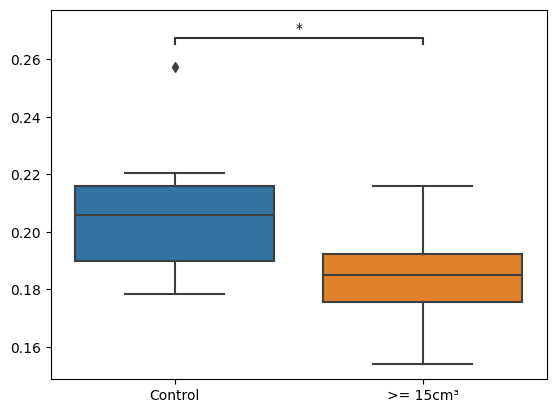

In [25]:
def plot_metastability_box(subjects_ms):
    # fig, ax = plt.subplots()

    s_none = subjects.filter_subjects(lambda sub: sub.get_tumor_type_and_grade() == 'none')
    s_tumor = subjects.filter_subjects(lambda sub: sub.get_tumor_type_and_grade() != 'none')
    s_meningioma = subjects.filter_subjects(lambda sub: 'Meningioma' in sub.get_tumor_type_and_grade())
    s_glioma = subjects.filter_subjects(lambda sub: sub.get_tumor_type_and_grade() != 'none' and 'Meningioma' not in sub.get_tumor_type_and_grade())
    s_plus_10_cm3 = subjects.filter_subjects(lambda sub: sub.get_tumor_size() >= 10.0)
    s_plus_15_cm3 = subjects.filter_subjects(lambda sub: sub.get_tumor_size() >= 15.0)
    s_plus_20_cm3 = subjects.filter_subjects(lambda sub: sub.get_tumor_size() >= 20.0)
    s_plus_30_cm3 = subjects.filter_subjects(lambda sub: sub.get_tumor_size() >= 30.0)

    data_none = {k: v.metastability for k, v in subjects_ms.items() if k in s_none.data}
    data_tumor = {k: v.metastability for k, v in subjects_ms.items() if k in s_tumor.data}
    data_meningioma = {k: v.metastability for k, v in subjects_ms.items() if k in s_meningioma.data}
    data_glioma = {k: v.metastability for k, v in subjects_ms.items() if k in s_glioma.data}
    data_plus_10_cm3 = {k: v.metastability for k, v in subjects_ms.items() if k in s_plus_10_cm3.data}
    data_plus_15_cm3 = {k: v.metastability for k, v in subjects_ms.items() if k in s_plus_15_cm3.data}
    data_plus_20_cm3 = {k: v.metastability for k, v in subjects_ms.items() if k in s_plus_20_cm3.data}
    data_plus_30_cm3 = {k: v.metastability for k, v in subjects_ms.items() if k in s_plus_30_cm3.data}

    # Convert data to nparray
    split_data = {
        'Control':  np.array(list(data_none.values())),
        # 'Tumor': np.array(list(data_tumor.values())),
        # 'Meningioma': np.array(list(data_meningioma.values())),
        # 'Glioma': np.array(list(data_glioma.values())),
        # '>= 10cm³': np.array(list(data_plus_10_cm3.values())),
        '>= 15cm³': np.array(list(data_plus_15_cm3.values())),
        # '>= 20cm³': np.array(list(data_plus_20_cm3.values())),
        # '>= 30cm³': np.array(list(data_plus_30_cm3.values()))
    }
    # plt.boxplot(split_data.values(), labels=split_data.keys())
    # plt.show()
    plotComparisonAcrossLabels2(split_data)

plot_metastability_box(preop_metastability_dk68)

## Compute Event Based Intrinsic Ignition

In [6]:
def compute_preop_event_based_intrinsic_ignition():
    preop_ts_dk68 = subjects.filter_preop_ts_dk68()
    result = dict()
    ebig_operator = EventBasedIntrinsicIgnition()

    for sub_id, ts_dk68 in preop_ts_dk68.items():
        tr = subjects.get_subject_by_id(sub_id).get_fmri_tr()/1000.0
        ebig_dk68 = ebig_operator.from_fMRI(
            ts_dk68,
            # Tagliazucchi, Enzo, Pablo Balenzuela, Daniel Fraiman, and Dante R. Chialvo. “Criticality in Large-Scale Brain FMRI Dynamics Unveiled by a Novel
            # Point Process Analysis.” Frontiers in Physiology 3 (2012). https://doi.org/10.3389/fphys.2012.00015.
            bold_filter=BOLDBandPassFilter(tr=tr, flp=0.01, fhi=0.1, k=2, remove_strong_artifacts=3.0)
        )
        result[sub_id] = ebig_dk68

    return result

preop_ebii_dk68 = compute_preop_event_based_intrinsic_ignition()

## Plot Event Based Intrinsict Ignition
&#x2BC1; **NOTE: We are taking the same number of snapshots for 2100 and 2400ms fMRI. IS THIS OK?**

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Control vs. Glioma: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.557e-02 U_stat=9.500e+01
Glioma vs. >= 10cm³: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:6.775e-01 U_stat=9.100e+01
Control vs. >= 10cm³: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.240e-02 U_stat=1.270e+02


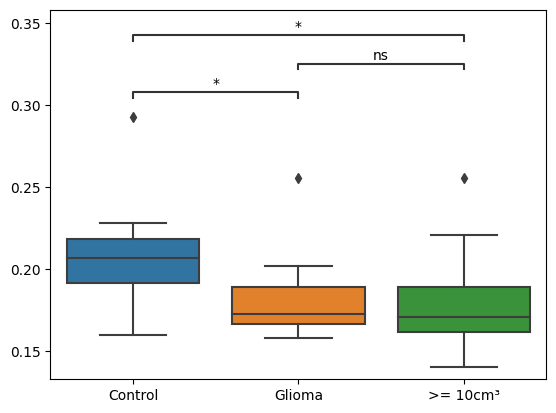

In [29]:
def plot_ebii_box(subjects_ebii):
    # fig, ax = plt.subplots()

    s_none = subjects.filter_subjects(lambda sub: sub.get_tumor_type_and_grade() == 'none')
    s_tumor = subjects.filter_subjects(lambda sub: sub.get_tumor_type_and_grade() != 'none')
    s_meningioma = subjects.filter_subjects(lambda sub: 'Meningioma' in sub.get_tumor_type_and_grade())
    s_glioma = subjects.filter_subjects(lambda sub: sub.get_tumor_type_and_grade() != 'none' and 'Meningioma' not in sub.get_tumor_type_and_grade())
    s_plus_10_cm3 = subjects.filter_subjects(lambda sub: sub.get_tumor_size() >= 10.0)
    s_plus_15_cm3 = subjects.filter_subjects(lambda sub: sub.get_tumor_size() >= 15.0)
    s_plus_20_cm3 = subjects.filter_subjects(lambda sub: sub.get_tumor_size() >= 20.0)
    s_plus_30_cm3 = subjects.filter_subjects(lambda sub: sub.get_tumor_size() >= 30.0)

    data_none = {k: v.mignition for k, v in subjects_ebii.items() if k in s_none.data}
    data_tumor = {k: v.mignition for k, v in subjects_ebii.items() if k in s_tumor.data}
    data_meningioma = {k: v.mignition for k, v in subjects_ebii.items() if k in s_meningioma.data}
    data_glioma = {k: v.mignition for k, v in subjects_ebii.items() if k in s_glioma.data}
    data_plus_10_cm3 = {k: v.mignition for k, v in subjects_ebii.items() if k in s_plus_10_cm3.data}
    data_plus_15_cm3 = {k: v.mignition for k, v in subjects_ebii.items() if k in s_plus_15_cm3.data}
    data_plus_20_cm3 = {k: v.mignition for k, v in subjects_ebii.items() if k in s_plus_20_cm3.data}
    data_plus_30_cm3 = {k: v.mignition for k, v in subjects_ebii.items() if k in s_plus_30_cm3.data}

    # Convert data to nparray
    split_data = {
        'Control':  np.array(list(data_none.values())),
        # 'Tumor': np.array(list(data_tumor.values())),
        # 'Meningioma': np.array(list(data_meningioma.values())),
        'Glioma': np.array(list(data_glioma.values())),
        '>= 10cm³': np.array(list(data_plus_10_cm3.values())),
        # '>= 15cm³': np.array(list(data_plus_15_cm3.values())),
        # '>= 20cm³': np.array(list(data_plus_20_cm3.values())),
        # '>= 30cm³': np.array(list(data_plus_30_cm3.values()))
    }
    # plt.boxplot(split_data.values(), labels=split_data.keys())
    # plt.show()
    plotComparisonAcrossLabels2(split_data)

plot_ebii_box(preop_ebii_dk68)